In [1]:
import numpy as np
from simfloat import *
import matplotlib.pyplot as plt

%matplotlib inline

# 基础研究方法说明

研究目标: 影响向量内积计算的浮点数量化误差的主要因素
LLM中主要的计算是矩阵乘法，而矩阵乘法可以看做是由向量内积构成的，因此我们主要研究：
1. 向量内积的浮点数量化误差受向量长度的影响；
2. 向量相关性对浮点数量化误差的影响；

## SIMFLOAT的使用

### 使用content定义浮点数
浮点数主要由三部分构成：
1. 符号位，通常为1 bit，0表示正数，1表示负数；
2. 指数位 (Exponent)：用于表示数值的量级
3. 尾数位 (Mantissa/Significand)：表示实际的数值精度

常见的浮点数类型的定义：
1. double（float64）：1s 11e 52m
2. single（float32）：1s 8e 23m
3. half（float16）：1s 5e 10m
4. bfloat16：1s 8e 7m

可以使用simfloat自定义一个浮点类型：

In [2]:
ftype = define_context(4, 3)
print(ftype(1.1))
print(ftype(1.1).as_decimal())

0 0111 001
1.125


### 使用simfloat进行浮点数运算

我们可以借助simfloat来进行浮点数运算，只需要定义两个浮点数，然后直接进行一些基础运算即可:

In [3]:
ftype = define_context(4, 3)
a = ftype(1.0)
b = ftype(2.0)
print(a+b)
print((a+b).as_decimal())

0 1000 100
3.0


## 向量内积的浮点数量化误差研究方法

1. 通过define_context定义需要的浮点数类型；
2. 通过numpy生成两个随机float64向量；
3. 分别在自定义的浮点类型与float64上计算向量内积，并计算误差的绝对值；

具体代码如下：

In [4]:
def gen_vectors(scale, size):
    a = np.random.normal(scale=scale, size=[size])
    b = np.random.normal(scale=scale, size=[size])
    return a, b

def dot_error(a, b, ctx=define_context(4, 3, "ROUND_HALF_UP"), factor=1.0):
    A = [ctx(x*factor) for x in a]
    B = [ctx(x*factor) for x in b]
    aa = np.array([float(ctx(x).as_decimal()) for x in a])
    bb = np.array([float(ctx(x).as_decimal()) for x in b])
    C = ctx(0)
    for x in [ x*y for x,y in zip(A,B )]:
        C = C+x
    gt = np.dot(a,b)
    ret = float((C).as_decimal())/factor/factor
    return np.abs(ret-gt)

测试一下上述代码，我们通过散点图观察下上述代码的输出：

In [5]:
scale = 0.01
sample_size = 200
samples = {
    128: [gen_vectors(scale, 128) for i in range(sample_size)],
    256: [gen_vectors(scale, 256) for i in range(sample_size)],
    512: [gen_vectors(scale, 512) for i in range(sample_size)],
    1024: [gen_vectors(scale, 1024) for i in range(sample_size)],
    2048: [gen_vectors(scale, 1024) for i in range(sample_size)],
    4096: [gen_vectors(scale, 1024) for i in range(sample_size)]
}

In [6]:
errors_scalenone = {
    128: [dot_error(a, b) for a,b in samples[128]],
    256: [dot_error(a, b) for a,b in samples[256]],
    1024: [dot_error(a, b) for a,b in samples[1024]],
    4096: [dot_error(a, b) for a,b in samples[4096]]
}

errors_scale64 = {
    128: [dot_error(a, b, factor=64.0) for a,b in samples[128]],
    256: [dot_error(a, b, factor=64.0) for a,b in samples[256]],
    1024: [dot_error(a, b, factor=64.0) for a,b in samples[1024]],
    4096: [dot_error(a, b, factor=64.0) for a,b in samples[4096]]
}

errors_scale128 = {
    128: [dot_error(a, b, factor=128.0) for a,b in samples[128]],
    256: [dot_error(a, b, factor=128.0) for a,b in samples[256]],
    1024: [dot_error(a, b, factor=128.0) for a,b in samples[1024]],
    4096: [dot_error(a, b, factor=128.0) for a,b in samples[4096]]
}

Text(0.5, 1.0, 'size=4096')

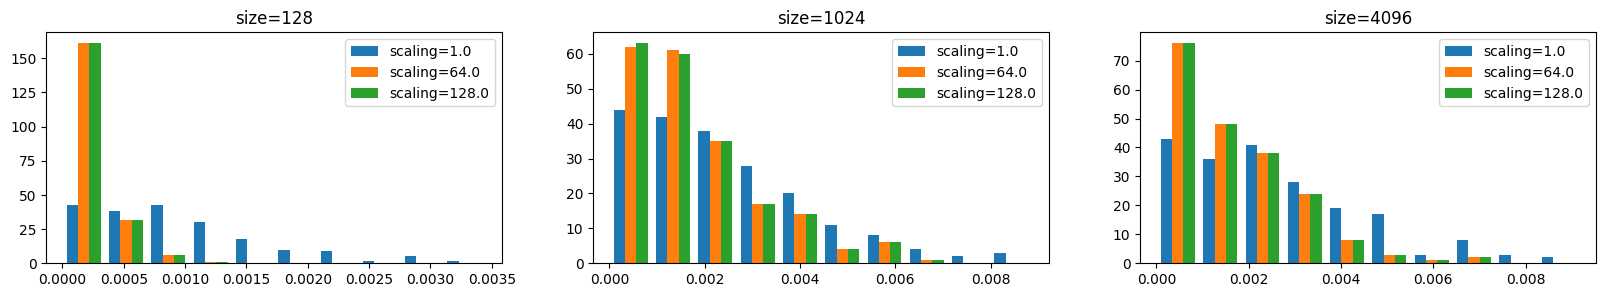

In [7]:
plt.figure(figsize=(20,3))

plt.subplot(1,3,1)
_ = plt.hist([errors_scalenone[128], errors_scale64[128], errors_scale128[128]])
plt.legend(["scaling=1.0", "scaling=64.0", "scaling=128.0"])
plt.title("size=128")

plt.subplot(1,3,2)
_ = plt.hist([errors_scalenone[1024], errors_scale64[1024], errors_scale128[1024]])
plt.legend(["scaling=1.0", "scaling=64.0", "scaling=128.0"])
plt.title("size=1024")

plt.subplot(1,3,3)
_ = plt.hist([errors_scalenone[4096], errors_scale64[4096], errors_scale128[4096]])
plt.legend(["scaling=1.0", "scaling=64.0", "scaling=128.0"])
plt.title("size=4096")

借助上述代码，我们很快便发现了浮点数量化误差随着向量长度而增长。由于该误差是一个随机变量，我们可以能通过研究其范围来给出结论。为了更好的观察这种计算误差，我们引入信噪比：
$$ SNR = 10 \times \log_{10} \frac{\sum{signal_i^2} }{\sum{nosie_i^2}}$$

### 整体scaling对信噪比的影响

In [8]:
def calculate_snr(signal, pred):
    signal = np.float64(signal)
    pred = np.float64(pred)
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean((signal - pred) ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def dot_error_snr(a, b, ctx=define_context(4, 3, "ROUND_HALF_UP"), factor=1.0):
    A = [ctx(x*factor) for x in a]
    B = [ctx(x*factor) for x in b]
    C = ctx(0)
    for x in [ x*y for x,y in zip(A,B )]:
        C = C+x
    gt = np.dot(a,b)
    ret = float((C).as_decimal())
    if factor != 1.0:
        ret = ret / factor / factor
    return calculate_snr(gt, ret)

In [9]:
snr_scalenone = {
    128: [dot_error_snr(a, b) for a,b in samples[128]],
    256: [dot_error_snr(a, b) for a,b in samples[256]],
    1024: [dot_error_snr(a, b) for a,b in samples[1024]],
    4096: [dot_error_snr(a, b) for a,b in samples[4096]]
}

snr_scale64 = {
    128: [dot_error_snr(a, b, factor=64.0) for a,b in samples[128]],
    256: [dot_error_snr(a, b, factor=64.0) for a,b in samples[256]],
    1024: [dot_error_snr(a, b, factor=64.0) for a,b in samples[1024]],
    4096: [dot_error_snr(a, b, factor=64.0) for a,b in samples[4096]]
}

snr_scale128 = {
    128: [dot_error_snr(a, b, factor=128.0) for a,b in samples[128]],
    256: [dot_error_snr(a, b, factor=128.0) for a,b in samples[256]],
    1024: [dot_error_snr(a, b, factor=128.0) for a,b in samples[1024]],
    4096: [dot_error_snr(a, b, factor=128.0) for a,b in samples[4096]]
}

Text(0.5, 1.0, 'size=4096')

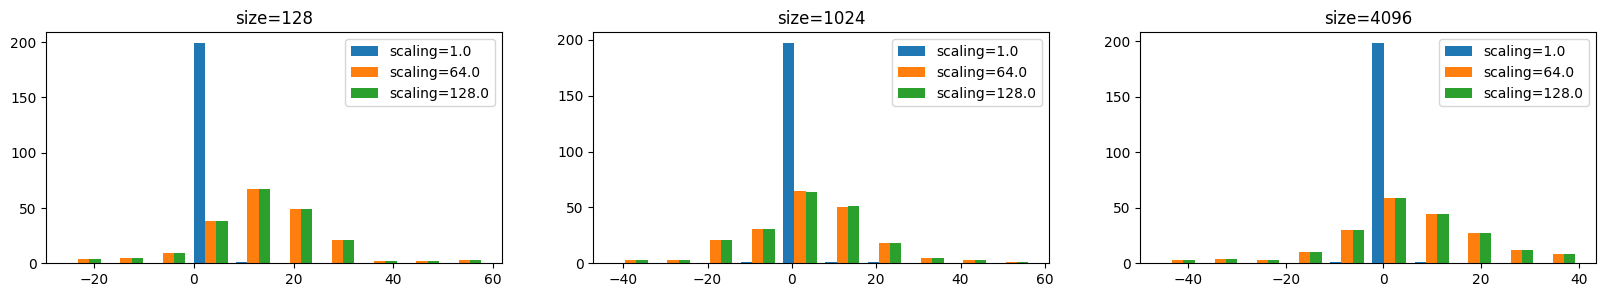

In [11]:
plt.figure(figsize=(20,3))

plt.subplot(1,3,1)
_ = plt.hist([snr_scalenone[128], snr_scale64[128], snr_scale128[128]])
plt.legend(["scaling=1.0", "scaling=64.0", "scaling=128.0"])
plt.title("size=128")

plt.subplot(1,3,2)
_ = plt.hist([snr_scalenone[1024], snr_scale64[1024], snr_scale128[1024]])
plt.legend(["scaling=1.0", "scaling=64.0", "scaling=128.0"])
plt.title("size=1024")

plt.subplot(1,3,3)
_ = plt.hist([snr_scalenone[4096], snr_scale64[4096], snr_scale128[4096]])
plt.legend(["scaling=1.0", "scaling=64.0", "scaling=128.0"])
plt.title("size=4096")

### 分块累加对信噪比的影响

In [12]:
def dot_error_snr_chunk(a, b, ctx=define_context(4, 3, "ROUND_HALF_UP"), factor=1.0, accsize=None):
    A = [ctx(x*factor) for x in a]
    B = [ctx(x*factor) for x in b]
    aa = np.array([float(ctx(x).as_decimal()) for x in a])
    bb = np.array([float(ctx(x).as_decimal()) for x in b])

    accsize = len(A) if accsize is None else accsize
    acc = 0.0
    cnt = 0
    C = ctx(0)
    for x in [ x*y for x,y in zip(A,B )]:
        C = C+x
        cnt += 1
        if cnt % accsize == 0:
            acc = acc + float((C).as_decimal())
            C = ctx(0)
    gt = np.dot(a,b)
    ret = acc + float((C).as_decimal())
    if factor != 1.0:
        ret = ret / factor / factor
    return calculate_snr(gt, ret)

In [14]:
snr_accsizenone = {
    128: [dot_error_snr_chunk(a, b, factor=64.) for a,b in samples[128]],
    256: [dot_error_snr_chunk(a, b, factor=64.) for a,b in samples[256]],
    1024: [dot_error_snr_chunk(a, b, factor=64.) for a,b in samples[1024]],
    4096: [dot_error_snr_chunk(a, b, factor=64.) for a,b in samples[4096]]
}

snr_accsize512 = {
    128: [dot_error_snr_chunk(a, b, factor=64.0, accsize=512) for a,b in samples[128]],
    256: [dot_error_snr_chunk(a, b, factor=64.0, accsize=512) for a,b in samples[256]],
    1024: [dot_error_snr_chunk(a, b, factor=64.0, accsize=512) for a,b in samples[1024]],
    4096: [dot_error_snr_chunk(a, b, factor=64.0, accsize=512) for a,b in samples[4096]]
}

snr_accsize128 = {
    128: [dot_error_snr_chunk(a, b, factor=64.0, accsize=128) for a,b in samples[128]],
    256: [dot_error_snr_chunk(a, b, factor=64.0, accsize=128) for a,b in samples[256]],
    1024: [dot_error_snr_chunk(a, b, factor=64.0, accsize=128) for a,b in samples[1024]],
    4096: [dot_error_snr_chunk(a, b, factor=64.0, accsize=128) for a,b in samples[4096]]
}

Text(0.5, 1.0, 'size=4096')

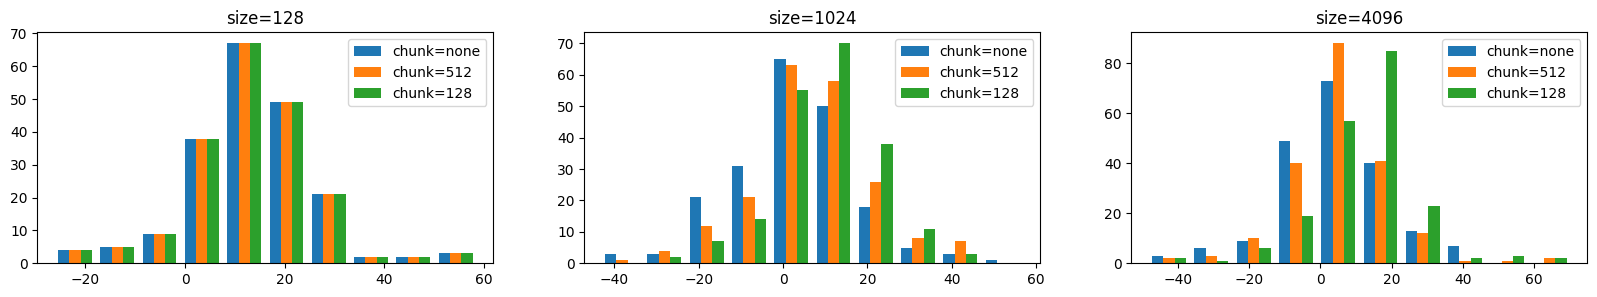

In [16]:
plt.figure(figsize=(20,3))

plt.subplot(1,3,1)
_ = plt.hist([snr_accsizenone[128], snr_accsize512[128], snr_accsize128[128]])
plt.legend(["chunk=none", "chunk=512", "chunk=128"])
plt.title("size=128")

plt.subplot(1,3,2)
_ = plt.hist([snr_accsizenone[1024], snr_accsize512[1024], snr_accsize128[1024]])
plt.legend(["chunk=none", "chunk=512", "chunk=128"])
plt.title("size=1024")

plt.subplot(1,3,3)
_ = plt.hist([snr_accsizenone[4096], snr_accsize512[4096], snr_accsize128[4096]])
plt.legend(["chunk=none", "chunk=512", "chunk=128"])
plt.title("size=4096")

### 分块Scaling对信噪比的影响

In [17]:
def dot_error_snr_chunk_scaling(a, b, ctx=define_context(4, 3, "ROUND_HALF_UP"), chunksize=None):
    A, B = [], []
    chunksize = 128 if chunksize is None else chunksize

    acc = 0
    acc_ctx = define_context(8, 8, "ROUND_HALF_UP")
    for offset in range(0, len(a), chunksize):
        slice_a = a[offset:offset+chunksize]
        max_a = np.max(np.abs(slice_a))
        factor_a = 224 / max_a

        slice_b = b[offset:offset+chunksize]
        max_b = np.max(np.abs(b[offset:offset+chunksize]))
        factor_b = 224 / max_b
        
        C = acc_ctx(0.0)
        for x,y in zip(slice_a, slice_b):
            try:
                A = ctx(x*factor_a)
                B = ctx(y*factor_b)
                A = acc_ctx(float(A.as_decimal()))
                B = acc_ctx(float(B.as_decimal()))
                C = C + A*B
            except:
                print("==== error:", x, y, A, B)
        C = float((C).as_decimal()) / factor_a / factor_b
        c = np.sum(slice_a * slice_b)
        acc += C
    gt = np.dot(a,b)
    ret = acc
    return calculate_snr(gt, ret)

In [18]:
snr_chunksizenone = {
    128: [dot_error_snr_chunk_scaling(a, b) for a,b in samples[128]],
    256: [dot_error_snr_chunk_scaling(a, b) for a,b in samples[256]],
    1024: [dot_error_snr_chunk_scaling(a, b) for a,b in samples[1024]],
    4096: [dot_error_snr_chunk_scaling(a, b) for a,b in samples[4096]]
}

snr_chunksize512 = {
    128: [dot_error_snr_chunk_scaling(a, b, chunksize=512) for a,b in samples[128]],
    256: [dot_error_snr_chunk_scaling(a, b, chunksize=512) for a,b in samples[256]],
    1024: [dot_error_snr_chunk_scaling(a, b, chunksize=512) for a,b in samples[1024]],
    4096: [dot_error_snr_chunk_scaling(a, b, chunksize=512) for a,b in samples[4096]]
}

snr_chunksize128 = {
    128: [dot_error_snr_chunk_scaling(a, b, chunksize=128) for a,b in samples[128]],
    256: [dot_error_snr_chunk_scaling(a, b, chunksize=128) for a,b in samples[256]],
    1024: [dot_error_snr_chunk_scaling(a, b, chunksize=128) for a,b in samples[1024]],
    4096: [dot_error_snr_chunk_scaling(a, b, chunksize=128) for a,b in samples[4096]]
}

==== error: -9.052864438008905e-08 -0.0047714555787617295 1 0000 000 1 1100 010
==== error: -0.0045155150062336944 -8.125994239719355e-08 1 10000011 11000000 1 0000 000
==== error: -9.052864438008905e-08 -0.0047714555787617295 1 0000 000 1 1100 001
==== error: -0.0045155150062336944 -8.125994239719355e-08 1 10000011 11000000 1 0000 000
==== error: -9.052864438008905e-08 -0.0047714555787617295 1 0000 000 1 1100 010
==== error: -0.0045155150062336944 -8.125994239719355e-08 1 10000011 11000000 1 0000 000


In [30]:
snr_chunksize64 = {
    128: [dot_error_snr_chunk_scaling(a, b, chunksize=64) for a,b in samples[128]],
    256: [dot_error_snr_chunk_scaling(a, b, chunksize=64) for a,b in samples[256]],
    1024: [dot_error_snr_chunk_scaling(a, b, chunksize=64) for a,b in samples[1024]],
    4096: [dot_error_snr_chunk_scaling(a, b, chunksize=64) for a,b in samples[4096]]
}

==== error: -9.052864438008905e-08 -0.0047714555787617295 1 0000 000 1 1100 010
==== error: -0.0045155150062336944 -8.125994239719355e-08 1 10000011 11000000 1 0000 000


Text(0.5, 1.0, 'size=4096')

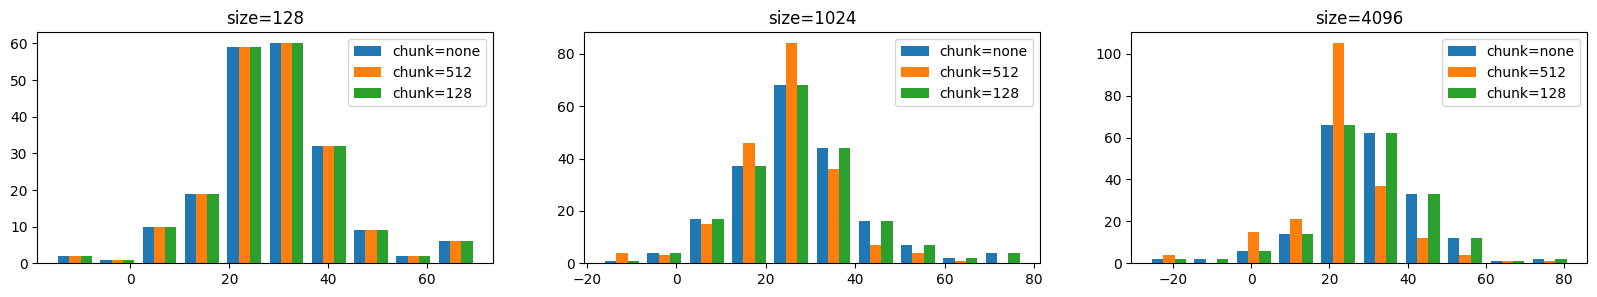

In [19]:
plt.figure(figsize=(20,3))

plt.subplot(1,3,1)
_ = plt.hist([snr_chunksizenone[128], snr_chunksize512[128], snr_chunksize128[128]])
plt.legend(["chunk=none", "chunk=512", "chunk=128"])
plt.title("size=128")

plt.subplot(1,3,2)
_ = plt.hist([snr_chunksizenone[1024], snr_chunksize512[1024], snr_chunksize128[1024]])
plt.legend(["chunk=none", "chunk=512", "chunk=128"])
plt.title("size=1024")

plt.subplot(1,3,3)
_ = plt.hist([snr_chunksizenone[4096], snr_chunksize512[4096], snr_chunksize128[4096]])
plt.legend(["chunk=none", "chunk=512", "chunk=128"])
plt.title("size=4096")

Text(0.5, 1.0, 'size=4096, chunksize selection')

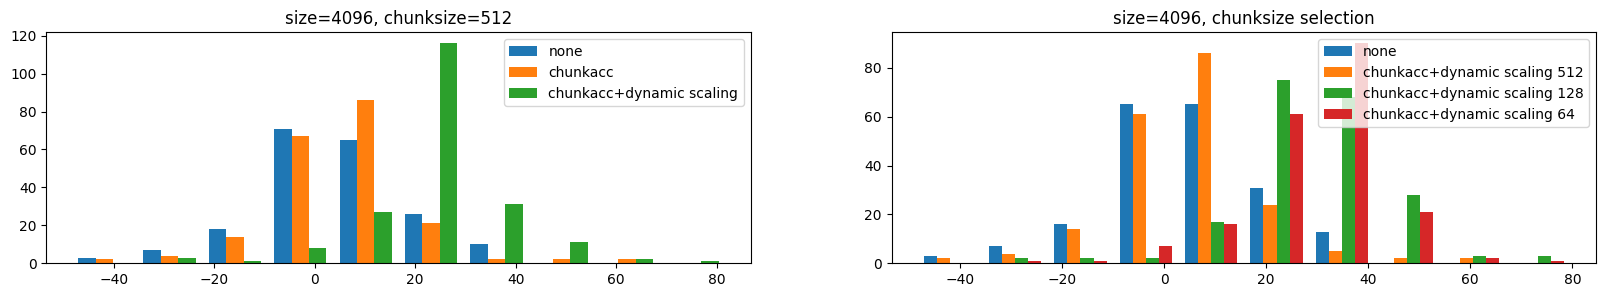

In [109]:
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
_ = plt.hist([snr_accsizenone[4096], snr_accsize512[4096], snr_chunksize512[4096]])
plt.legend(["none", "chunkacc", "chunkacc+dynamic scaling"])
plt.title("size=4096, chunksize=512")

plt.subplot(1,2,2)
_ = plt.hist([snr_accsizenone[4096], snr_accsize512[4096], snr_chunksize128[4096], snr_chunksize64[4096]])
plt.legend(["none", "chunkacc+dynamic scaling 512", "chunkacc+dynamic scaling 128", "chunkacc+dynamic scaling 64"])
plt.title("size=4096, chunksize selection")

# 浮点数向量内积计算的量化误差分析

根据前边的分析和说明，我们认为影响量化误差的主要因素有两个：
1. 向量长度，已经在前一节进行了初步验证，本节将进行定性和定量分析；
2. 向量之间的相关性，本节将进行系统性分析；

## 生成两个相关的随机向量

可以通过在第二个向量中混合第一个向量来人为制造相关性，代码如下：

In [35]:
def generate_correlated_vectors_simple(scale, n_dim, rho):
    z1 = np.random.normal(0, scale, (n_dim,))
    z2 = np.random.normal(0, scale, (n_dim,))
    return z1, rho * z1 + (1 - rho) * z2

验证一下该方法的正确性：

In [36]:
a, b = generate_correlated_vectors_simple(0.1, 1000, 0.2)
np.dot(a,b) / np.sqrt( np.dot(a,a) * np.dot(b,b) )

0.2638477070945996

In [37]:
a, b = generate_correlated_vectors_simple(0.5, 1000, 0.03)
np.dot(a,b) / np.sqrt( np.dot(a,a) * np.dot(b,b) )

0.04524967200840629

通过两个测试发现上述方法基本可用，但是相关性误差略高。不过不影响我们得到一些想要的结论。

In [77]:
scale = 0.01
sample_size = 200
corrvecs001 = {
    128: [generate_correlated_vectors_simple(scale, 128, 0.01) for i in range(sample_size)],
    256: [generate_correlated_vectors_simple(scale, 256, 0.01) for i in range(sample_size)],
    512: [generate_correlated_vectors_simple(scale, 512, 0.01) for i in range(sample_size)],
    1024: [generate_correlated_vectors_simple(scale, 1024, 0.01) for i in range(sample_size)],
    2048: [generate_correlated_vectors_simple(scale, 1024, 0.01) for i in range(sample_size)],
    4096: [generate_correlated_vectors_simple(scale, 1024, 0.01) for i in range(sample_size)],
}
corrvecs01 = {
    128: [generate_correlated_vectors_simple(scale, 128, 0.1) for i in range(sample_size)],
    256: [generate_correlated_vectors_simple(scale, 256, 0.1) for i in range(sample_size)],
    512: [generate_correlated_vectors_simple(scale, 512, 0.1) for i in range(sample_size)],
    1024: [generate_correlated_vectors_simple(scale, 1024, 0.1) for i in range(sample_size)],
    2048: [generate_correlated_vectors_simple(scale, 1024, 0.1) for i in range(sample_size)],
    4096: [generate_correlated_vectors_simple(scale, 1024, 0.1) for i in range(sample_size)],
}

corrvecs02 = {
    128: [generate_correlated_vectors_simple(scale, 128, 0.2) for i in range(sample_size)],
    256: [generate_correlated_vectors_simple(scale, 256, 0.2) for i in range(sample_size)],
    512: [generate_correlated_vectors_simple(scale, 512, 0.2) for i in range(sample_size)],
    1024: [generate_correlated_vectors_simple(scale, 1024, 0.2) for i in range(sample_size)],
    2048: [generate_correlated_vectors_simple(scale, 1024, 0.2) for i in range(sample_size)],
    4096: [generate_correlated_vectors_simple(scale, 1024, 0.2) for i in range(sample_size)],
}

## 两个向量量化后计算内积的量化误差

In [78]:
errors_scale64_rho001 = {
    128: [dot_error(a, b, factor=64.0) for a,b in corrvecs001[128]],
    256: [dot_error(a, b, factor=64.0) for a,b in corrvecs001[256]],
    1024: [dot_error(a, b, factor=64.0) for a,b in corrvecs001[1024]],
    4096: [dot_error(a, b, factor=64.0) for a,b in corrvecs001[4096]]
}

errors_scale64_rho01 = {
    128: [dot_error(a, b, factor=64.0) for a,b in corrvecs01[128]],
    256: [dot_error(a, b, factor=64.0) for a,b in corrvecs01[256]],
    1024: [dot_error(a, b, factor=64.0) for a,b in corrvecs01[1024]],
    4096: [dot_error(a, b, factor=64.0) for a,b in corrvecs01[4096]]
}

errors_scale64_rho02 = {
    128: [dot_error(a, b, factor=64.0) for a,b in corrvecs02[128]],
    256: [dot_error(a, b, factor=64.0) for a,b in corrvecs02[256]],
    1024: [dot_error(a, b, factor=64.0) for a,b in corrvecs02[1024]],
    4096: [dot_error(a, b, factor=64.0) for a,b in corrvecs02[4096]]
}

首先定性分析下向量长度、向量相关性与不同量化方法的影响：

Text(0.5, 1.0, 'size=4096')

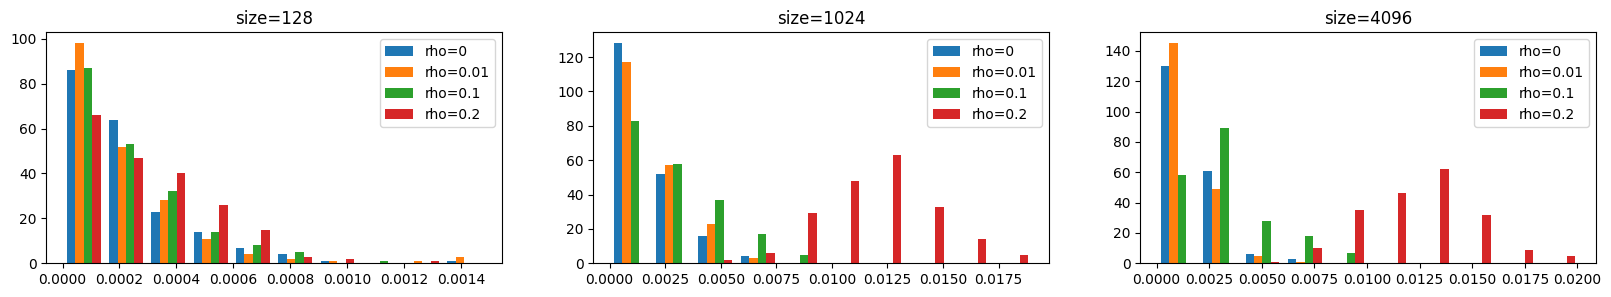

In [79]:
plt.figure(figsize=(20,3))

plt.subplot(1,3,1)
_ = plt.hist([errors_scale64[128], errors_scale64_rho001[128], errors_scale64_rho01[128], errors_scale64_rho02[128]])
plt.legend(["rho=0", "rho=0.01", "rho=0.1", "rho=0.2"])
plt.title("size=128")

plt.subplot(1,3,2)
_ = plt.hist([errors_scale64[1024], errors_scale64_rho001[1024], errors_scale64_rho01[1024], errors_scale64_rho02[1024]])
plt.legend(["rho=0", "rho=0.01", "rho=0.1", "rho=0.2"])
plt.title("size=1024")

plt.subplot(1,3,3)
_ = plt.hist([errors_scale64[4096], errors_scale64_rho001[4096], errors_scale64_rho01[4096], errors_scale64_rho02[4096]])
plt.legend(["rho=0", "rho=0.01", "rho=0.1", "rho=0.2"])
plt.title("size=4096")

实验测试了三个不同的向量长度下(128、1024和4096)，FP8的计算误差。可以发现，不管是哪一个向量长度，相关性越大，计算误差越大。为了更加清晰直观的观察误差，我们使用箱图（boxplot）来观察信噪比：

In [80]:
snr_scale64_rho001 = {
    128: [dot_error_snr(a, b, factor=64.0) for a,b in corrvecs001[128]],
    256: [dot_error_snr(a, b, factor=64.0) for a,b in corrvecs001[256]],
    1024: [dot_error_snr(a, b, factor=64.0) for a,b in corrvecs001[1024]],
    4096: [dot_error_snr(a, b, factor=64.0) for a,b in corrvecs001[4096]]
}

snr_scale64_rho01 = {
    128: [dot_error_snr(a, b, factor=64.0) for a,b in corrvecs01[128]],
    256: [dot_error_snr(a, b, factor=64.0) for a,b in corrvecs01[256]],
    1024: [dot_error_snr(a, b, factor=64.0) for a,b in corrvecs01[1024]],
    4096: [dot_error_snr(a, b, factor=64.0) for a,b in corrvecs01[4096]]
}

snr_scale64_rho02 = {
    128: [dot_error_snr(a, b, factor=64.0) for a,b in corrvecs02[128]],
    256: [dot_error_snr(a, b, factor=64.0) for a,b in corrvecs02[256]],
    1024: [dot_error_snr(a, b, factor=64.0) for a,b in corrvecs02[1024]],
    4096: [dot_error_snr(a, b, factor=64.0) for a,b in corrvecs02[4096]]
}

Text(0.5, 1.0, 'size=4096')

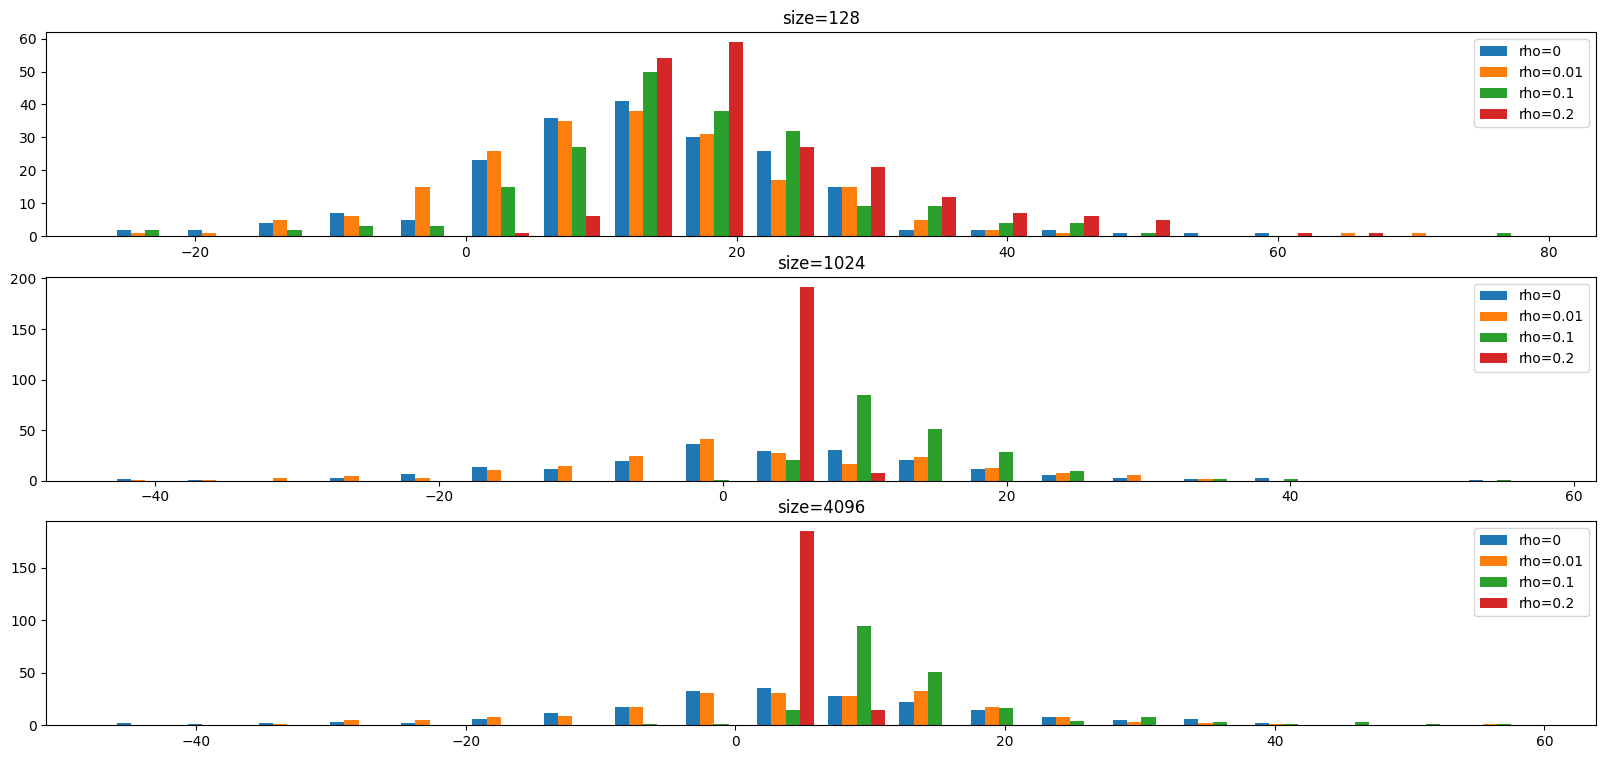

In [97]:
plt.figure(figsize=(20,9))

plt.subplot(3,1,1)
_ = plt.hist([snr_scale64[128], snr_scale64_rho001[128], snr_scale64_rho01[128], snr_scale64_rho02[128]], bins=20)
plt.legend(["rho=0", "rho=0.01", "rho=0.1", "rho=0.2"])
plt.title("size=128")

plt.subplot(3,1,2)
_ = plt.hist([snr_scale64[1024], snr_scale64_rho001[1024], snr_scale64_rho01[1024], snr_scale64_rho02[1024]], bins=20)
plt.legend(["rho=0", "rho=0.01", "rho=0.1", "rho=0.2"])
plt.title("size=1024")

plt.subplot(3,1,3)
_ = plt.hist([snr_scale64[4096], snr_scale64_rho001[4096], snr_scale64_rho01[4096], snr_scale64_rho02[4096]], bins=20)
plt.legend(["rho=0", "rho=0.01", "rho=0.1", "rho=0.2"])
plt.title("size=4096")

In [103]:
snr_scale64_accsize512_rho001 = {
    128: [dot_error_snr_chunk(a, b, factor=64., accsize=512) for a,b in corrvecs001[128]],
    256: [dot_error_snr_chunk(a, b, factor=64., accsize=512) for a,b in corrvecs001[256]],
    1024: [dot_error_snr_chunk(a, b, factor=64., accsize=512) for a,b in corrvecs001[1024]],
    4096: [dot_error_snr_chunk(a, b, factor=64., accsize=512) for a,b in corrvecs001[4096]]
}

snr_scale64_accsize128_rho001 = {
    128: [dot_error_snr_chunk(a, b, factor=64., accsize=128) for a,b in corrvecs001[128]],
    256: [dot_error_snr_chunk(a, b, factor=64., accsize=128) for a,b in corrvecs001[256]],
    1024: [dot_error_snr_chunk(a, b, factor=64., accsize=128) for a,b in corrvecs001[1024]],
    4096: [dot_error_snr_chunk(a, b, factor=64., accsize=128) for a,b in corrvecs001[4096]]
}

snr_scale64_accsize512_rho01 = {
    128: [dot_error_snr_chunk(a, b, factor=64., accsize=512) for a,b in corrvecs01[128]],
    256: [dot_error_snr_chunk(a, b, factor=64., accsize=512) for a,b in corrvecs01[256]],
    1024: [dot_error_snr_chunk(a, b, factor=64., accsize=512) for a,b in corrvecs01[1024]],
    4096: [dot_error_snr_chunk(a, b, factor=64., accsize=512) for a,b in corrvecs01[4096]]
}

snr_scale64_accsize128_rho01 = {
    128: [dot_error_snr_chunk(a, b, factor=64., accsize=128) for a,b in corrvecs01[128]],
    256: [dot_error_snr_chunk(a, b, factor=64., accsize=128) for a,b in corrvecs01[256]],
    1024: [dot_error_snr_chunk(a, b, factor=64., accsize=128) for a,b in corrvecs01[1024]],
    4096: [dot_error_snr_chunk(a, b, factor=64., accsize=128) for a,b in corrvecs01[4096]]
}

Text(0.5, 1.0, 'size=4096, rho=0.1')

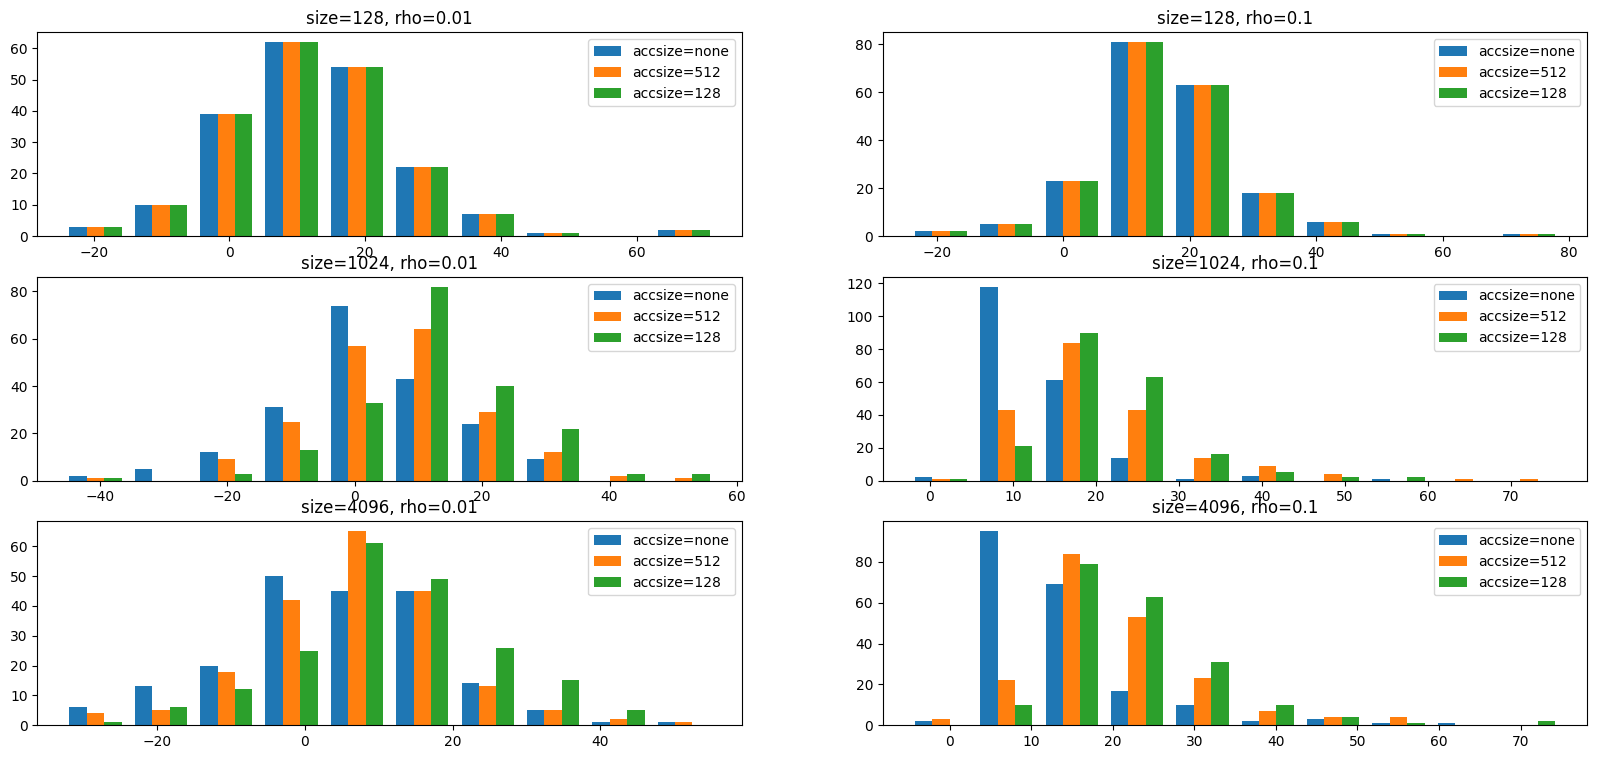

In [106]:
plt.figure(figsize=(20,9))

plt.subplot(3,2,1)
_ = plt.hist([snr_scale64_rho001[128], snr_scale64_accsize512_rho001[128], snr_scale64_accsize128_rho001[128]])
plt.legend(["accsize=none", "accsize=512", "accsize=128"])
plt.title("size=128, rho=0.01")

plt.subplot(3,2,3)
_ = plt.hist([snr_scale64_rho001[1024], snr_scale64_accsize512_rho001[1024], snr_scale64_accsize128_rho001[1024]])
plt.legend(["accsize=none", "accsize=512", "accsize=128"])
plt.title("size=1024, rho=0.01")

plt.subplot(3,2,5)
_ = plt.hist([snr_scale64_rho001[4096], snr_scale64_accsize512_rho001[4096], snr_scale64_accsize128_rho001[4096]])
plt.legend(["accsize=none", "accsize=512", "accsize=128"])
plt.title("size=4096, rho=0.01")

plt.subplot(3,2,2)
_ = plt.hist([snr_scale64_rho01[128], snr_scale64_accsize512_rho01[128], snr_scale64_accsize128_rho01[128]])
plt.legend(["accsize=none", "accsize=512", "accsize=128"])
plt.title("size=128, rho=0.1")

plt.subplot(3,2,4)
_ = plt.hist([snr_scale64_rho01[1024], snr_scale64_accsize512_rho01[1024], snr_scale64_accsize128_rho01[1024]])
plt.legend(["accsize=none", "accsize=512", "accsize=128"])
plt.title("size=1024, rho=0.1")

plt.subplot(3,2,6)
_ = plt.hist([snr_scale64_rho01[4096], snr_scale64_accsize512_rho01[4096], snr_scale64_accsize128_rho01[4096]])
plt.legend(["accsize=none", "accsize=512", "accsize=128"])
plt.title("size=4096, rho=0.1")

In [107]:
snr_scale64_chunksize512_rho001 = {
    128: [dot_error_snr_chunk_scaling(a, b, chunksize=512) for a,b in corrvecs001[128]],
    256: [dot_error_snr_chunk_scaling(a, b, chunksize=512) for a,b in corrvecs001[256]],
    1024: [dot_error_snr_chunk_scaling(a, b, chunksize=512) for a,b in corrvecs001[1024]],
    4096: [dot_error_snr_chunk_scaling(a, b, chunksize=512) for a,b in corrvecs001[4096]]
}

snr_scale64_chunksize128_rho001 = {
    128: [dot_error_snr_chunk_scaling(a, b, chunksize=128) for a,b in corrvecs001[128]],
    256: [dot_error_snr_chunk_scaling(a, b, chunksize=128) for a,b in corrvecs001[256]],
    1024: [dot_error_snr_chunk_scaling(a, b, chunksize=128) for a,b in corrvecs001[1024]],
    4096: [dot_error_snr_chunk_scaling(a, b, chunksize=128) for a,b in corrvecs001[4096]]
}

snr_scale64_chunksize512_rho01 = {
    128: [dot_error_snr_chunk_scaling(a, b, chunksize=512) for a,b in corrvecs01[128]],
    256: [dot_error_snr_chunk_scaling(a, b, chunksize=512) for a,b in corrvecs01[256]],
    1024: [dot_error_snr_chunk_scaling(a, b, chunksize=512) for a,b in corrvecs01[1024]],
    4096: [dot_error_snr_chunk_scaling(a, b, chunksize=512) for a,b in corrvecs01[4096]]
}

snr_scale64_chunksize128_rho01 = {
    128: [dot_error_snr_chunk_scaling(a, b, chunksize=128) for a,b in corrvecs01[128]],
    256: [dot_error_snr_chunk_scaling(a, b, chunksize=128) for a,b in corrvecs01[256]],
    1024: [dot_error_snr_chunk_scaling(a, b, chunksize=128) for a,b in corrvecs01[1024]],
    4096: [dot_error_snr_chunk_scaling(a, b, chunksize=128) for a,b in corrvecs01[4096]]
}

==== error: -1.3562603356340726e-07 0.007263446624218395 1 0000 000 0 1100 110
==== error: -7.389298654952316e-08 -0.006512128138167764 1 0000 000 1 1100 011
==== error: -6.2072897071114755e-09 0.015431145758160075 1 0000 000 0 1101 100
==== error: -7.389298654952316e-08 -0.006512128138167764 1 0000 000 1 1101 000
==== error: -6.2072897071114755e-09 0.015431145758160075 1 0000 000 0 1110 000
==== error: -5.4736330133883206e-08 -0.010648319265762029 1 0000 000 1 1101 001
==== error: -6.76576119272143e-08 0.018929425299855328 1 0000 000 0 1110 001
==== error: -0.0009163332389311582 -1.0122988279535352e-08 1 10000001 10000000 1 0000 000
==== error: -2.939155523772495e-08 -0.009929509911000963 1 0000 000 1 1101 010
==== error: 0.006021679021789588 -1.3063536273419992e-07 0 10000100 01100000 1 0000 000
==== error: -5.4736330133883206e-08 -0.010648319265762029 1 0000 000 1 1101 011
==== error: -6.76576119272143e-08 0.018929425299855328 1 0000 000 0 1110 011
==== error: -0.0009163332389311582

Text(0.5, 1.0, 'size=4096, rho=0.1')

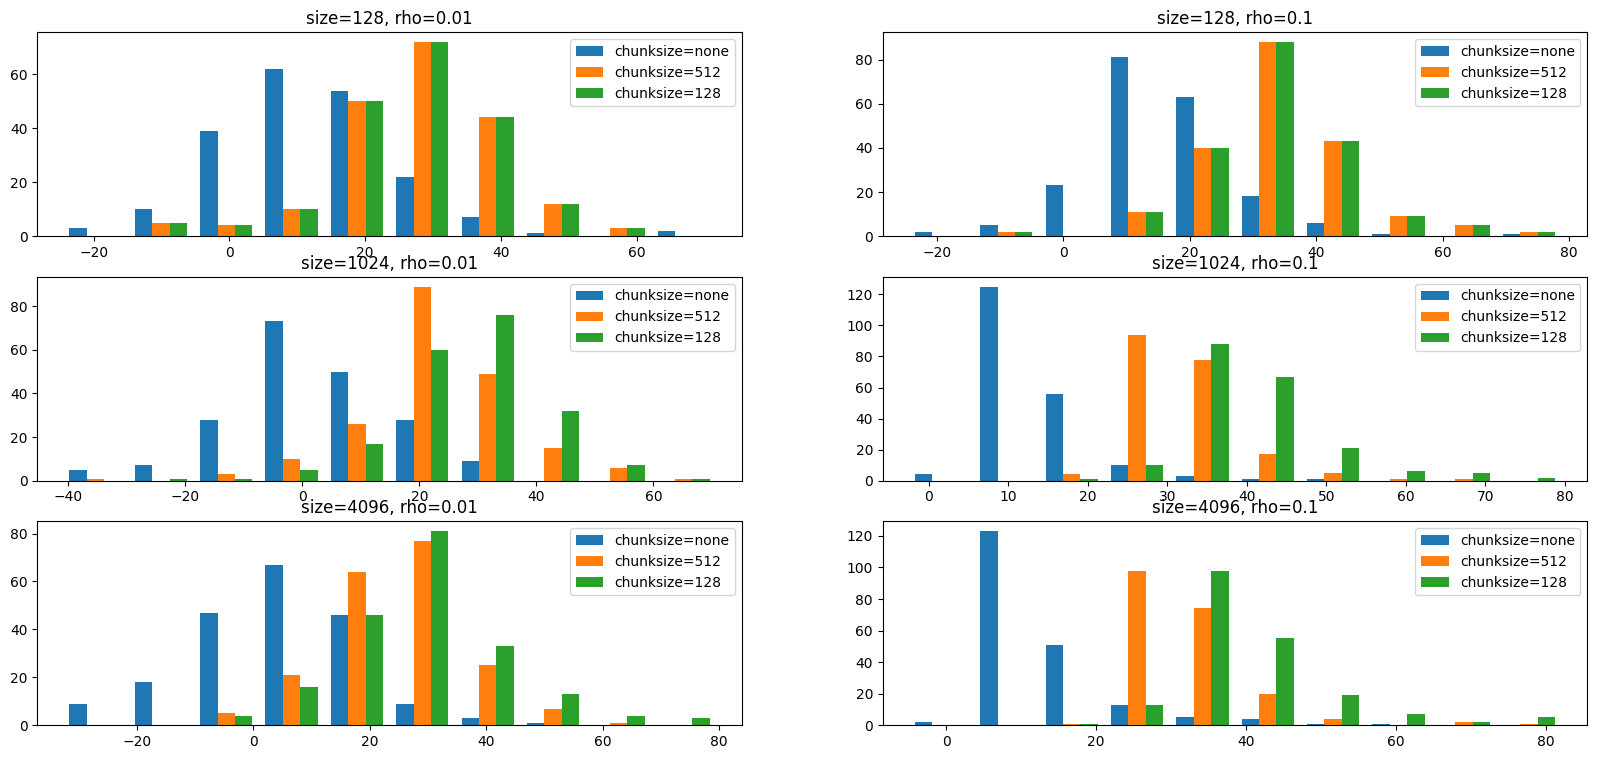

In [108]:
plt.figure(figsize=(20,9))

plt.subplot(3,2,1)
_ = plt.hist([snr_scale64_rho001[128], snr_scale64_chunksize512_rho001[128], snr_scale64_chunksize128_rho001[128]])
plt.legend(["chunksize=none", "chunksize=512", "chunksize=128"])
plt.title("size=128, rho=0.01")

plt.subplot(3,2,3)
_ = plt.hist([snr_scale64_rho001[1024], snr_scale64_chunksize512_rho001[1024], snr_scale64_chunksize128_rho001[1024]])
plt.legend(["chunksize=none", "chunksize=512", "chunksize=128"])
plt.title("size=1024, rho=0.01")

plt.subplot(3,2,5)
_ = plt.hist([snr_scale64_rho001[4096], snr_scale64_chunksize512_rho001[4096], snr_scale64_chunksize128_rho001[4096]])
plt.legend(["chunksize=none", "chunksize=512", "chunksize=128"])
plt.title("size=4096, rho=0.01")

plt.subplot(3,2,2)
_ = plt.hist([snr_scale64_rho01[128], snr_scale64_chunksize512_rho01[128], snr_scale64_chunksize128_rho01[128]])
plt.legend(["chunksize=none", "chunksize=512", "chunksize=128"])
plt.title("size=128, rho=0.1")

plt.subplot(3,2,4)
_ = plt.hist([snr_scale64_rho01[1024], snr_scale64_chunksize512_rho01[1024], snr_scale64_chunksize128_rho01[1024]])
plt.legend(["chunksize=none", "chunksize=512", "chunksize=128"])
plt.title("size=1024, rho=0.1")

plt.subplot(3,2,6)
_ = plt.hist([snr_scale64_rho01[4096], snr_scale64_chunksize512_rho01[4096], snr_scale64_chunksize128_rho01[4096]])
plt.legend(["chunksize=none", "chunksize=512", "chunksize=128"])
plt.title("size=4096, rho=0.1")